In [1]:
### Notebook for loading the ephys data ##

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy
import seaborn as sns

def LoadSpikeTimes(bs, MinCluId=2):

        res = pd.read_csv(bs+'.res', header=None, squeeze=True).values
        clu = pd.read_csv(bs+'.clu', squeeze=True).values
        if MinCluId is not None:
                mask = clu >= MinCluId
                clu = clu[mask]
                res = res[mask]
                
        return res,clu
    
def LoadUnits(b, par=None):
    
        '''Load "units" information (mostly from des-file).

        INPUT:
        - [b]:       <str> containing "block base"

        OUTPUT:
        - [trodes]:  <DataFrame>'''

        ## If not provided, load the par-file information
        if par is None:
                par = LoadPar(b)

        ## For each tetrode, read in its "per tetode" des-file
        trode_index = range(1, len(par['trode_ch'])+1)
        units = [pd.read_csv(b+'.des.'+str(t), header=None, names=['des']) for t in trode_index]
        units = pd.concat(units, keys=trode_index, names=['trode','trode_unit']).reset_index()

        all_trodes = pd.read_csv(b+'.des', header=None, names=['des'])
        if ~np.all(all_trodes.des == units.des):
                units.des = all_trodes.des

        ## Let the "index per tetrode" and the index of this <DataFrame> start from 2(!) instead of 0
        units['trode_unit'] += 2
        units.index += 2

        ## Return the "unit"-information as <DataFrame>
        return unitspd.read_csv(b+'.clu'+t, squeeze=True).values
    
def loadDes(b):
        # returns des matched to clu id
        des = pd.read_csv(b+'.des', header=None, names=['des'])
        des.index +=2
        return des
    
# REMEMBER TO CHANGE THIS TO MATCH THE PATH IN YOUR COMPUTER
b = '/Users/caitlinashcroft/Stats/Project/Project 9/mvl10-200109' #basename 
bs = b+'_'+str(2)

res,clu = LoadSpikeTimes(bs)
cycles = np.load(bs+'.theta.cycles.7')
des = loadDes(b) # des indices correspond to the cell ids in the clu file

def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')
  print(len(bins), len(hist))


In [2]:
#Set up dataframes for res, clu, and des - inspect to see makeup of data

dfres = pd.DataFrame(res)
dfclu = pd.DataFrame(clu)
dfdes = pd.DataFrame(des)


#Combine to generate dataframe containing all datasets

#Note: first to columns are 'noise' clusters 

recording_data = pd.concat([dfres,dfclu], axis = 1)
recording_data.columns = ['Res', 'Cluster']
recording_data


,Res,Cluster
0,6,37
1,21,3
2,425,13
3,650,3
4,796,8
...,...,...
441759,30099436,18
441760,30099450,3
441761,30099452,67
441762,30099453,3


In [3]:
# To assign cell id to each cluster, match cluster in .clu file to corresponding id in .des file

cluster = []
L = []

for index, row in recording_data.iterrows():

   cluster = row['Cluster']
   id = dfdes.loc[cluster]
   value = str(id[0])
   L.append(value)

In [4]:
#Add cell id to dataframe

dfdes = pd.DataFrame(L)
recording_data = pd.concat([recording_data, dfdes], axis = 1)
recording_data.columns = ['Res', 'Cluster', 'Description']
recording_data

,Res,Cluster,Description
0,6,37,p1
1,21,3,b3
2,425,13,b3
3,650,3,b3
4,796,8,b3
...,...,...,...
441759,30099436,18,b3
441760,30099450,3,b3
441761,30099452,67,p1
441762,30099453,3,b3


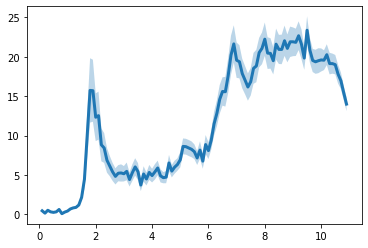

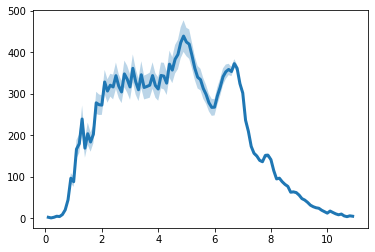

In [5]:
#Define edges of spike time bins to enable comparison across clusters

binedges = np.arange(np.log2(1),np.log2(2000),.1) 

#Examine number of clusters (67)

clus = np.unique(clu) 

#Create empty array equal in length to the number of clusters

counts = np.zeros((len(clus),len(binedges)-1)) 

#Iterate through clusters

for clui,clu_ in enumerate(clus): 

     
#Calculate spiketimes by dividing 'res' values by 20 (20,000 Hz samples dividd by 20 gives ms)

        spktimes = res[clu==clu_]/20 

#Calculate ISI for each cluster

         

        isi_ = np.log2(np.diff(spktimes)) 

         
#Populate empty counts array with interspike intervals with a given bin

        counts[clui],_ = np.histogram(isi_,binedges) 

#Create a 'mask' to identify clusters of a given cell type         

mask_p1 = des['des'].values=='p1' 
mask_b1 = des['des'].values=='b1' 

#Calculate mean ISI for this cell type

meanISI_p1 = np.mean(counts[mask_p1,:],axis=0)
meanISI_b1 = np.mean(counts[mask_b1,:],axis=0) 

#Calculate sem of ISI for this cell type

std_p1 = np.std(counts[mask_p1,:],axis=0)
std_b1 = np.std(counts[mask_b1,:],axis=0) 

n_p1 = len(meanISI_p1) 
n_b1 = len(meanISI_b1) 

sem_p1 = std_p1/np.sqrt(n_p1) 
sem_b1 = std_b1/np.sqrt(n_b1) 

#Plot mean ISI w SEM 
a
plt.plot(binedges[1:],meanISI_p1,lw=3)

plt.fill_between(binedges[1:],meanISI_p1-sem_p1,meanISI_p1+sem_p1,alpha=.3) 
plt.title('')

plt.pause(1) 

plt.plot(binedges[1:],meanISI_b1,lw=3) 
plt.fill_between(binedges[1:],meanISI_b1-sem_b1,meanISI_b1+sem_b1,alpha=.3)

In [6]:
# Compute mean firing for p1 and b1 cells 

# #Isolate cells w p1 description
rasta_data_p1 = []
p1_cells = recording_data.loc[recording_data['Description'] == 'p1']
singleP1Cells = p1_cells['Cluster'].unique()
for i in singleP1Cells:
    df = []
    df = p1_cells.loc[p1_cells['Cluster'] == i]
    samples = (max(df['Res']) - min(df['Res']))
    time = samples/20000
    meanSpike = len(df['Res'])/time
    print('The mean firing rate for Cluster ', i, 'is: ', meanSpike)
    rasta_data_p1.append(np.array(df['Res']/20))

The mean firing rate for Cluster  37 is:  1.3169698280216993
The mean firing rate for Cluster  60 is:  1.204726848454167
The mean firing rate for Cluster  36 is:  1.4977924023150204
The mean firing rate for Cluster  52 is:  0.5588810084448916
The mean firing rate for Cluster  28 is:  0.09459851915478115
The mean firing rate for Cluster  31 is:  0.5595439122140448
The mean firing rate for Cluster  55 is:  3.0891177567434434
The mean firing rate for Cluster  58 is:  0.5950929829461311
The mean firing rate for Cluster  44 is:  2.8680533181221857
The mean firing rate for Cluster  56 is:  0.017091278983476357
The mean firing rate for Cluster  26 is:  0.47636833811187546
The mean firing rate for Cluster  53 is:  2.4598444208302634
The mean firing rate for Cluster  69 is:  1.814173925412846
The mean firing rate for Cluster  40 is:  0.5408058673440505
The mean firing rate for Cluster  48 is:  2.276084456497563
The mean firing rate for Cluster  54 is:  1.7117306877051344
The mean firing rate fo

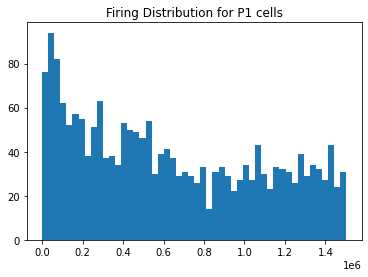

21 20


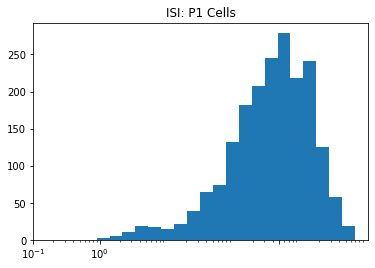

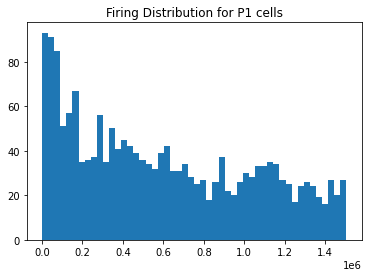

21 20


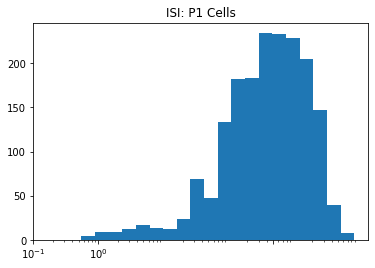

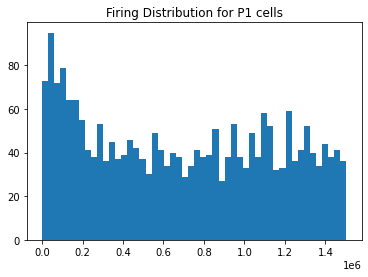

21 20


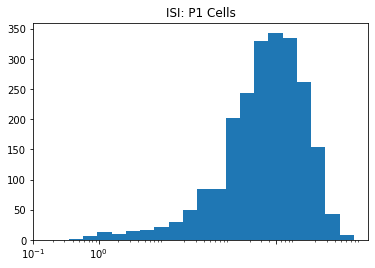

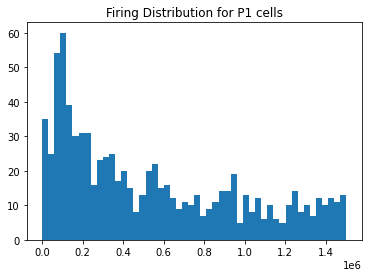

21 20


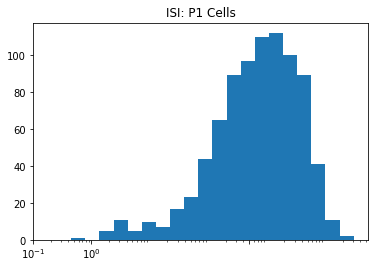

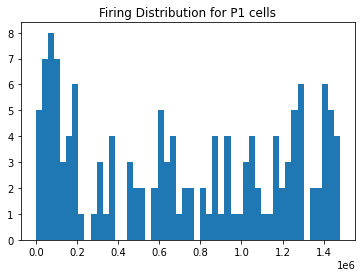

21 20


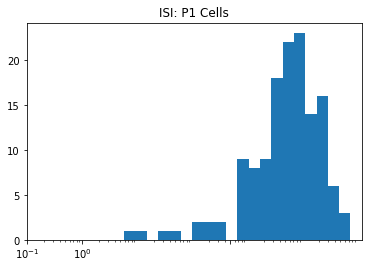

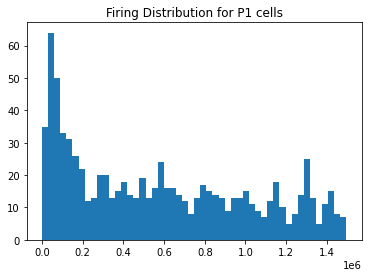

21 20


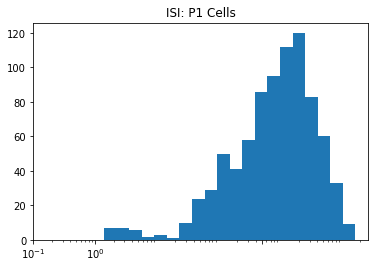

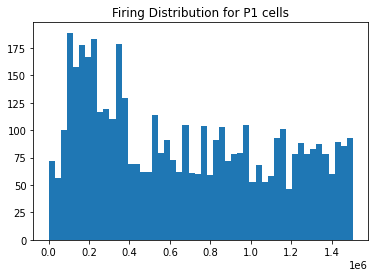

21 20


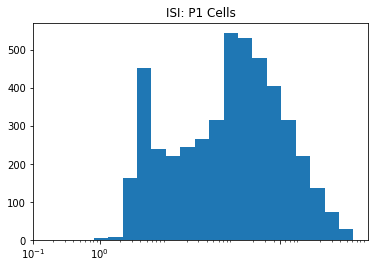

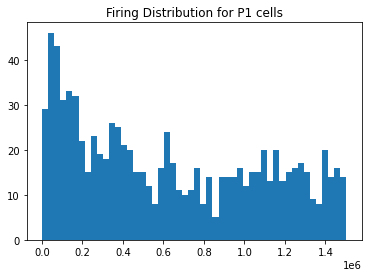

21 20


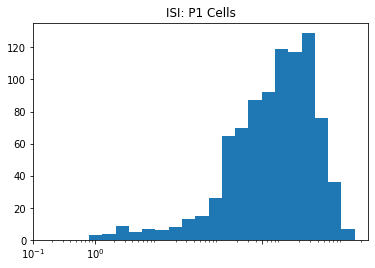

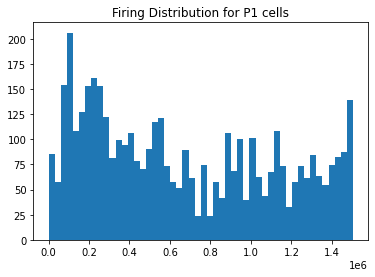

21 20


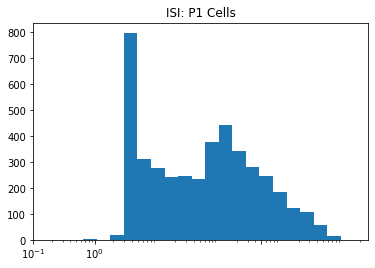

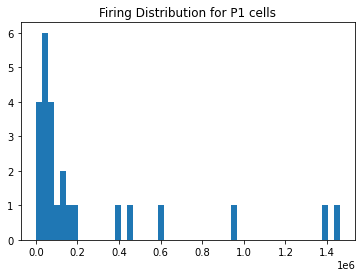

21 20


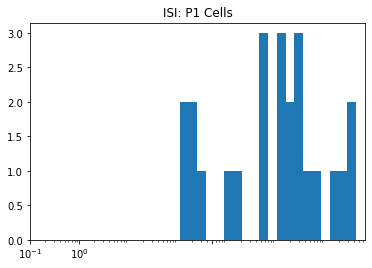

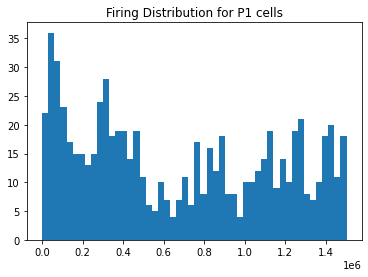

21 20


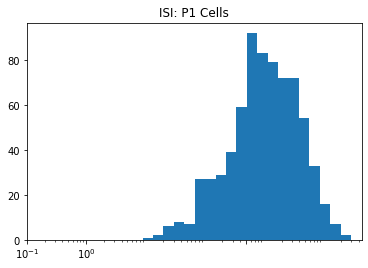

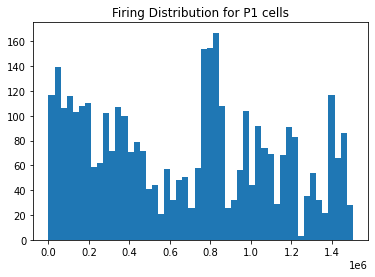

21 20


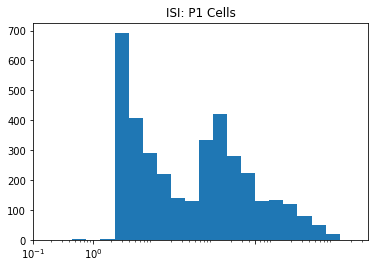

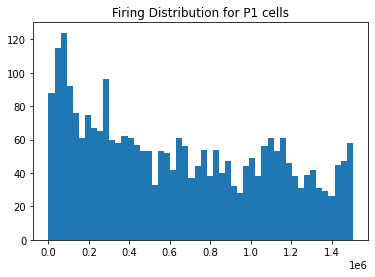

21 20


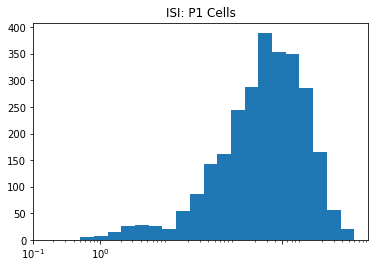

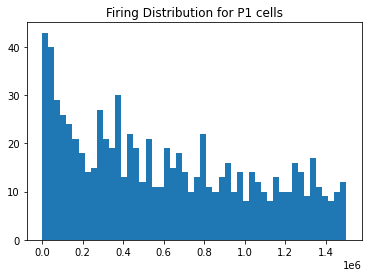

21 20


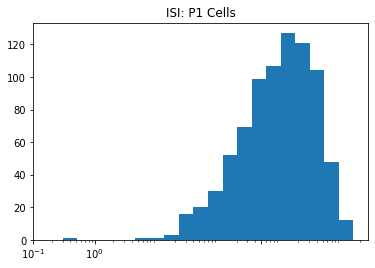

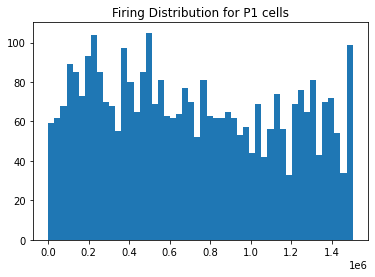

21 20


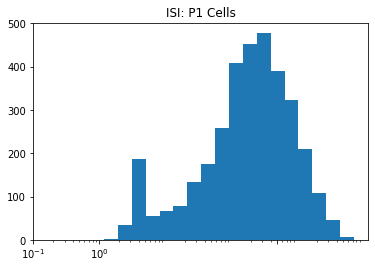

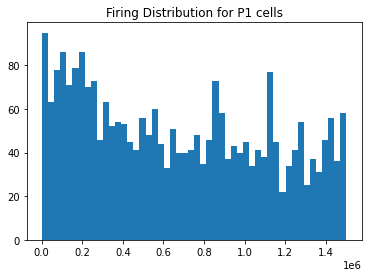

21 20


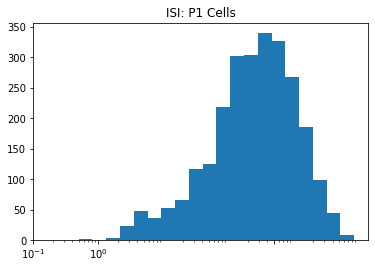

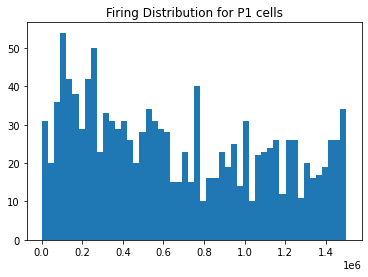

21 20


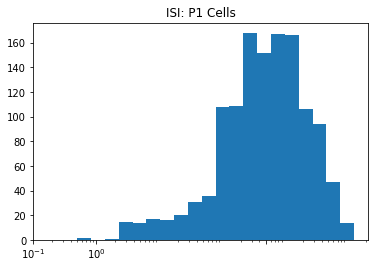

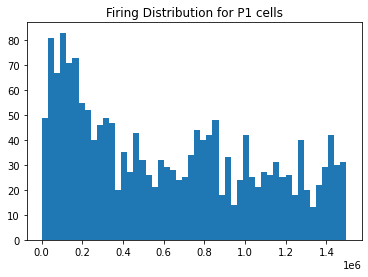

21 20


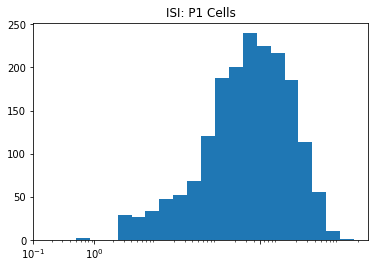

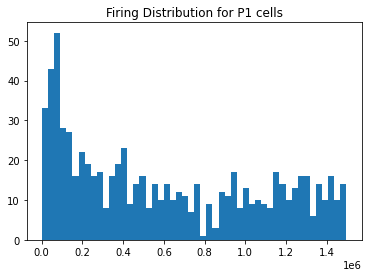

21 20


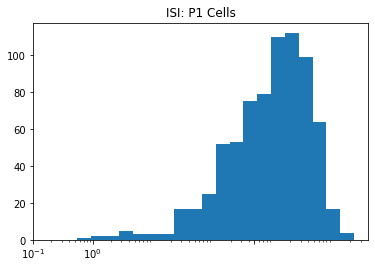

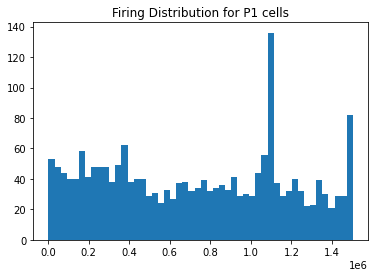

21 20


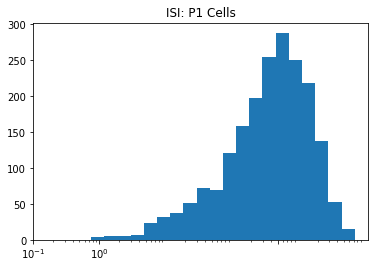

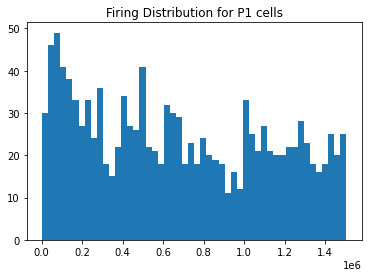

21 20


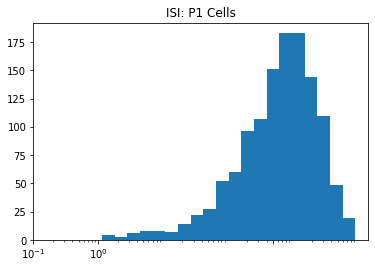

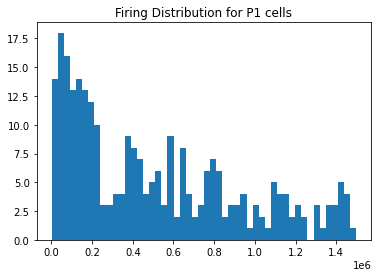

21 20


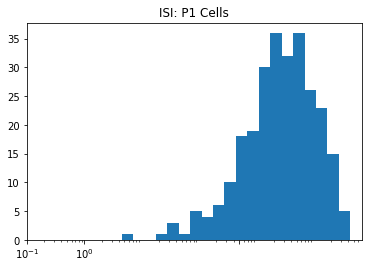

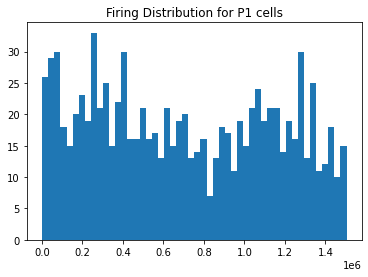

21 20


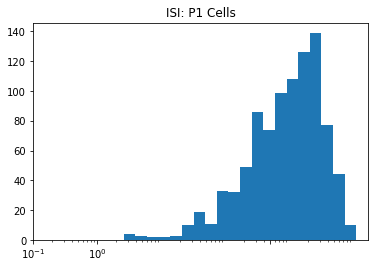

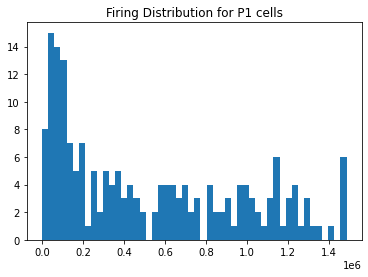

21 20


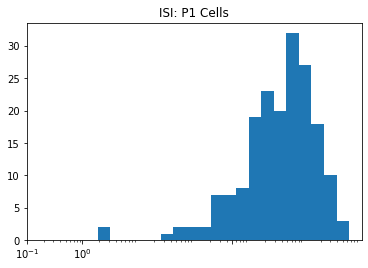

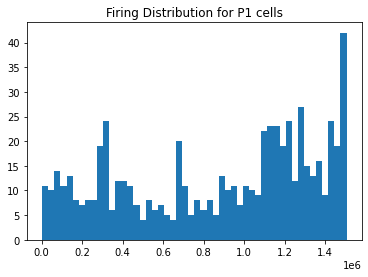

21 20


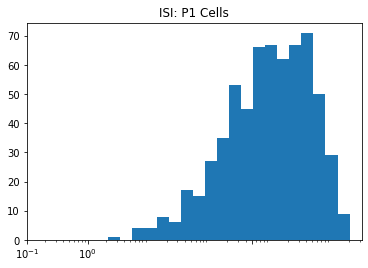

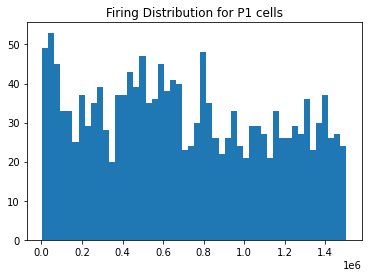

21 20


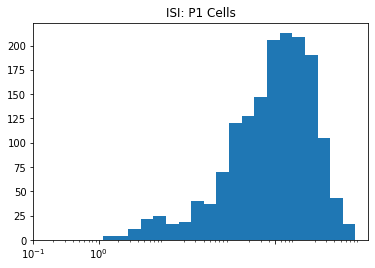

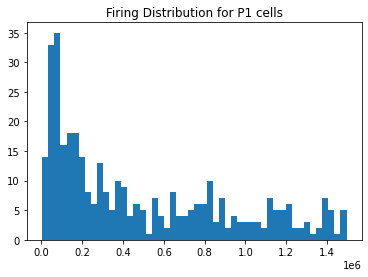

21 20


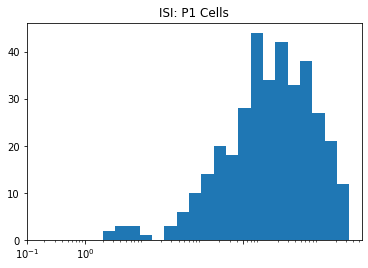

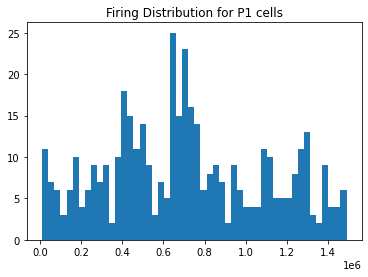

21 20


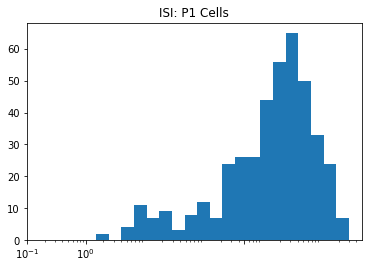

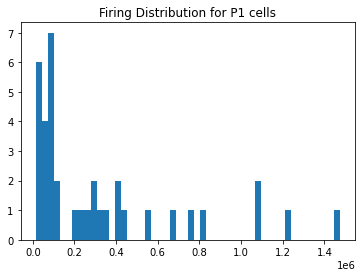

21 20


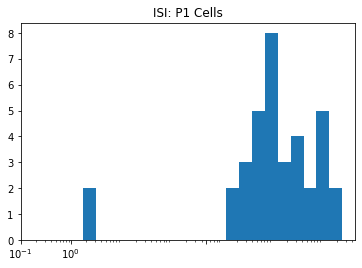

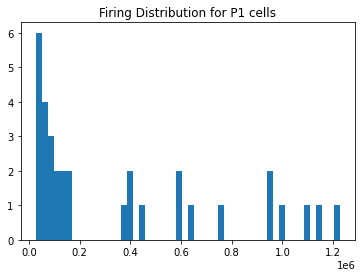

21 20


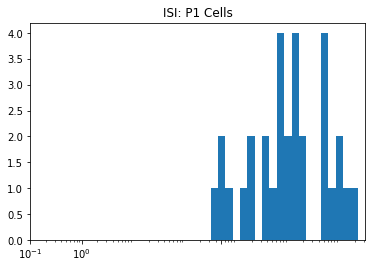

31 30


Text(0, 0.5, 'Frequency')

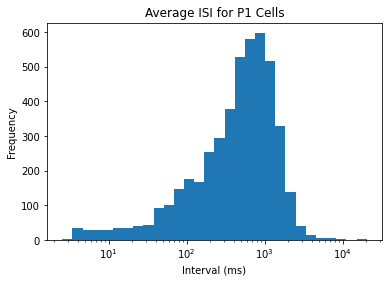

In [8]:
# Plot interspike interval

# Plot interspike interval

ISI_df_p1 =[]

for column in rasta_data_p1:

    plt.figure()
    plt.hist(column, bins = 50)
    plt.title('Firing Distribution for P1 cells')
    plt.pause(1)

    plt.figure()
    plot_loghist(np.diff(column), 20)
    plt.title('ISI: P1 Cells')
    plt.xticks([0.1, 1, 500])
    plt.pause(2)

    ISI_df_p1.append(np.diff(column))

ISI_df_p1 = pd.DataFrame(ISI_df_p1)
ISI_df_mean = np.mean(ISI_df_p1)
plot_loghist(ISI_df_mean, bins = 30)
plt.title('Average ISI for P1 Cells')
plt.xlabel('Interval (ms)')
plt.ylabel('Frequency')

21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20
21 20


Text(0, 0.5, 'Frequency')

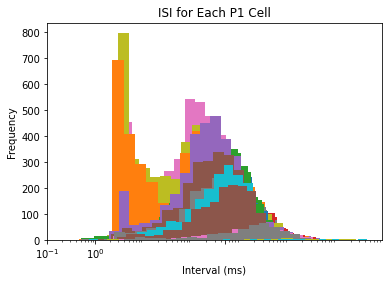

In [9]:
#interspike interval distribution for each P1 cell 

for column in rasta_data_p1:

    plot_loghist(np.diff(column), 20)
    plt.title('ISI: B1 Cells')
    plt.xticks([0.1, 1, 500])
    plt.title('ISI for Each P1 Cell')
    plt.xlabel('Interval (ms)')
    plt.ylabel('Frequency')

In [10]:
#Same for b1

#Extract spikes that correspond to b1 cell id

b1_cells = recording_data.loc[recording_data['Description'] == 'b1']

#identify unique clusters in b1 group

singleB1Cells = b1_cells['Cluster'].unique()

rasta_data_b1 = []

#calculate mean firing rate for each cluster 

for i in singleB1Cells:
    df = []
    df = b1_cells.loc[b1_cells['Cluster'] == i]
    samples = (max(df['Res']) - min(df['Res'])) 
    time = samples/20000
    meanSpike = len(df['Res'])/time
    print('The mean firing rate for Cluster ', i, 'is: ', meanSpike, 'spikes per second')

    #save spike times (in milliseconds) in an array for further analyses 

    rasta_data_b1.append(np.array(df['Res']/20))


The mean firing rate for Cluster  41 is:  32.01103262292616 spikes per second
The mean firing rate for Cluster  65 is:  13.481017572937699 spikes per second
The mean firing rate for Cluster  57 is:  7.555355268012541 spikes per second
The mean firing rate for Cluster  61 is:  5.956623769954366 spikes per second


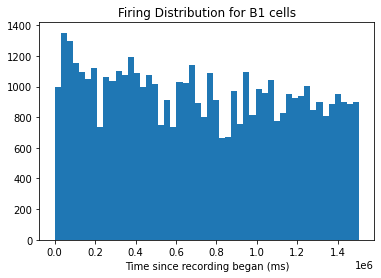

21 20


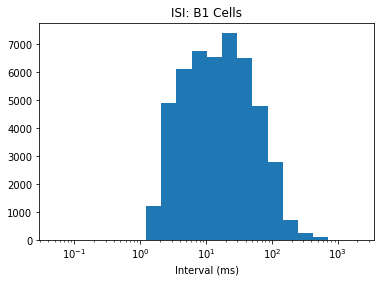

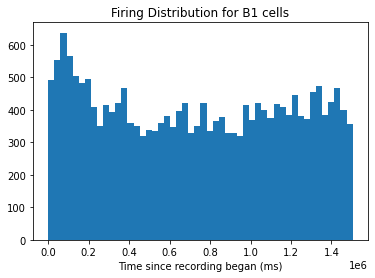

21 20


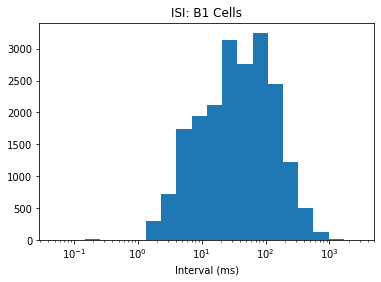

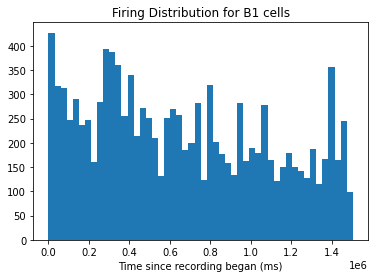

21 20


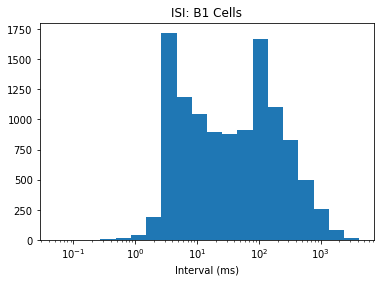

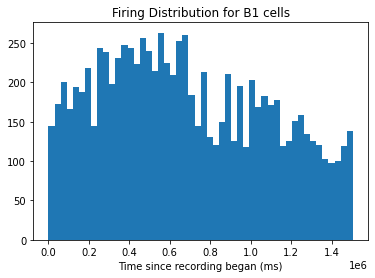

21 20


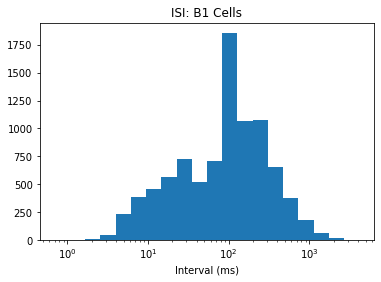

31 30


Text(0, 0.5, 'Frequency')

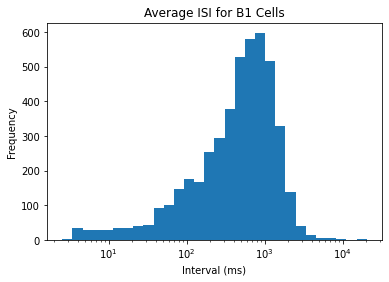

In [12]:
# Plot interspike interval

ISI_df_b1 =[]

for column in rasta_data_b1:

    plt.figure()
    plt.hist(column, bins = 50)
    plt.title('Firing Distribution for B1 cells')
    plt.xlabel('Time since recording began (ms)')
    plt.pause(1)

    plt.figure()
    plot_loghist(np.diff(column), 20)
    plt.title('ISI: B1 Cells')
    plt.xlabel('Interval (ms)')
    plt.pause(2)

    ISI_df_b1.append(np.diff(column))

ISI_df_b1 = pd.DataFrame(ISI_df_b1)
ISI_df_b1_mean = np.mean(ISI_df_b1)
plot_loghist(ISI_df_mean, bins = 30)
plt.title('Average ISI for B1 Cells')
plt.xlabel('Interval (ms)')
plt.ylabel('Frequency')

21 20
21 20
21 20
21 20


Text(0, 0.5, 'Frequency')

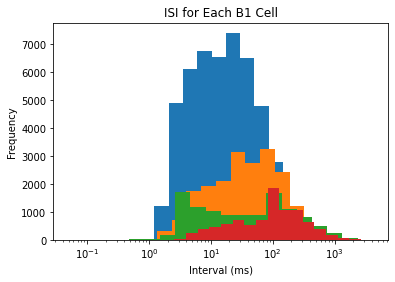

In [13]:
#interspike interval distribution for each B1 cell 

for column in rasta_data_b1:

    plot_loghist(np.diff(column), 20)
    plt.title('ISI: B1 Cells')
    plt.title('ISI for Each B1 Cell')
plt.xlabel('Interval (ms)')
plt.ylabel('Frequency')

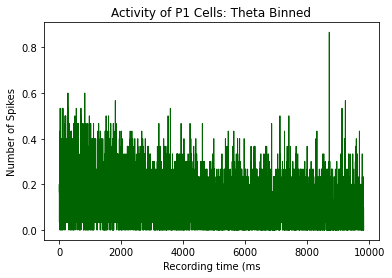

Text(0.5, 1.0, 'Activity of P1 Cells: Theta Binned')

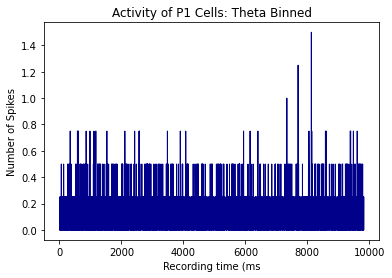

In [4]:
#####Analysis of theta cycles#### 

#Define edges of spike time bins to enable comparison across clusters
cyedges = (cycles[:,np.array([0,4])].flatten())/1.25

#Create empty array equal in length to the number of cycles

counts = np.zeros((len(clu),len(cycles))) 

#Iterate through clusters

clus = np.unique(clu)

for clui,clu_ in enumerate(clus): 

     
# #Calculate spiketimes by dividing 'res' values by 20 (20,000 Hz samples dividd by 20 gives ms)

        spktimes = res[clu==clu_]/20 

         
#Populate empty counts array with interspike intervals with a given bin

        counts_ = np.histogram(spktimes,cyedges)[0] 
        counts_ = np.concatenate((counts_[0:-1:2], [counts_[-1]]))
        counts[clui] = counts_

# #Create a 'mask' to identify clusters of a given cell type         
mask_p1 = des.des[des.des == 'p1'].index.tolist()
mask_b1 = des.des[des.des == 'b1'].index.tolist()

#Calculate mean spikes in each bin across cell types 

mean_spks_p1 = np.mean(counts[mask_p1,:], axis = 0)
mean_spks_b1 = np.mean(counts[mask_b1,:], axis = 0)

# # #Plot mean spikes for each theta bin

binnumber = np.arange(len(cycles))

plt.plot(binnumber,mean_spks_p1,lw=1, color = 'darkgreen')
plt.xlabel('Recording time (ms')
plt.ylabel('Number of Spikes')
plt.title('Activity of P1 Cells: Theta Binned')

plt.pause(1)

plt.plot(binnumber,mean_spks_b1,lw=1, color = 'darkblue')
plt.xlabel('Recording time (ms'))
plt.ylabel('Mean Number of Spikes')
plt.title('Activity of P1 Cells: Theta Binned')


(441764, 9823) (30, 15)


Text(0.5, 1.0, 'Variance Explained by 15 Principal Components')

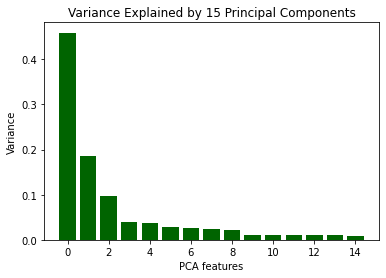

In [5]:
###PCA on P1_Cells###

#Extract spike times for p1 cells from counts 

p1_counts = counts[mask_p1,:]

# Perform PCA (assuming no of appropriate factors has already been determined)

pca = PCA(n_components = 15).fit(p1_counts)
X_pca = pca.transform(p1_counts)
PCA_components = pd.DataFrame(X_pca)
print(counts.shape, X_pca.shape)

#Plot explained variance against PCs

plt.subplots()
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='darkgreen')
plt.xlabel('PCA features')
plt.ylabel('Variance')
plt.title('Variance Explained by 15 Principal Components')

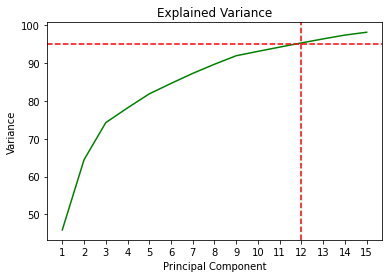

[0.45911128 0.18534161 0.09814782 0.03886452 0.03717658 0.02751211
 0.02656565 0.02418628 0.02244861 0.01155223 0.01125334 0.01109294
 0.01060961 0.01007835 0.00748562]


In [69]:
#Plot the % variance explained by each component 
#Examine number of PCs required to explain 95% of the variance 

plt.figure()
sns.lineplot(data = (np.cumsum(pca.explained_variance_ratio_)*100), color = 'green')
plt.xlabel('Principal Component')
plt.ylabel('Variance %') #for each component
plt.title('Explained Variance')
plt.axhline(y=95, color='r', linestyle='--')
plt.axvline(x=11, color='r', linestyle='--')
plt.xticks(np.arange(15), ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15'))
plt.show()


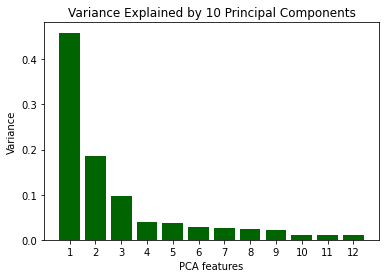

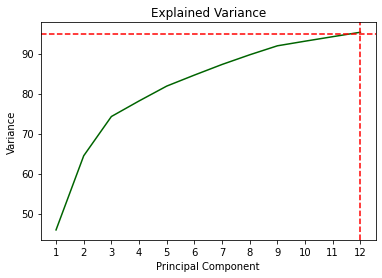

[0.45911128 0.18534161 0.09814782 0.03886452 0.03717658 0.02751211
 0.02656565 0.02418628 0.02244861 0.01155223 0.01125334 0.01109294]


In [70]:
#Re-run PCA with sufficient components to explained 95% of the variance 

pca = PCA(n_components = 12).fit(p1_counts)
X_pca = pca.transform(p1_counts)
PCA_components = pd.DataFrame(X_pca)

# # Plot variance explained

plt.subplots()
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='darkgreen')
plt.xlabel('PCA features')
plt.ylabel('Variance')
plt.title('Variance Explained by 10 Principal Components')
plt.xticks(np.arange(12), ('1','2','3','4','5','6','7','8','9','10','11','12'))

eigenvalues = pca.explained_variance_

#Plot the % variance explained by each PC 

plt.figure()
plt.plot((np.cumsum(pca.explained_variance_ratio_)*100), color = 'darkgreen')
plt.xlabel('Principal Component')
plt.ylabel('Variance %') #for each component
plt.title('Explained Variance')
plt.axhline(y=95, color='r', linestyle='--')
plt.axvline(x=11, color='r', linestyle='--')
plt.xticks(np.arange(12), ('1','2','3','4','5','6','7','8','9','10','11','12'))
plt.show()


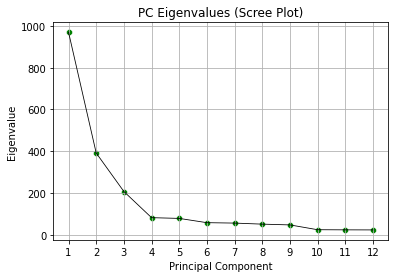

In [71]:
#Generate a screeplot plotting the eigenvalues for each PC 

plt.subplots()
sns.scatterplot(features, pca.explained_variance_, color = 'green')
plt.plot(features, pca.explained_variance_, linewidth=0.8, color = 'black')
plt.title('PC Eigenvalues (Scree Plot)')
plt.xlabel('Principal Component')
plt.xticks(np.arange(12), ('1','2','3','4','5','6','7','8','9','10','11','12'))
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()